In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
spark = SparkSession.builder.getOrCreate()

import json
import pyspark.sql.functions as F
import pyspark.sql.types as T
from datetime import datetime,timedelta,date
from pyspark import SparkContext
import ast
from pyspark.sql import Window
import seaborn as sns

In [3]:
data_location = pd.read_csv('/content/SERS_train.csv')
data = pd.DataFrame(data_location)

test =data.dropna()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()
df_train = spark.createDataFrame(test) 
df_train.show(10,False)

+-------+--------+--------+---------------------+------+-------------+------------------+------+----------+----------+---------+----------+------------------+
|edge_id|length  |way_type|way_name             |eta   |timestamp    |coverage          |ata   |latitude  |longitude |is_tunnel|user_group|way_segments_count|
+-------+--------+--------+---------------------+------+-------------+------------------+------+----------+----------+---------+----------+------------------+
|165    |36.713  |7       |توحیدی               |13.007|1641423595457|1.1149456595756022|7.475 |35.768834 |51.4694875|0.0      |B         |1                 |
|286    |68.373  |7       |بوستان               |9.116 |1641188168444|0.9988050838781368|9.999 |35.8001555|51.4748499|0.0      |A         |1                 |
|455    |76.896  |7       |آذر                  |6.291 |1642397104643|0.9697557740324592|7.004 |32.645556 |51.6593476|0.0      |A         |3                 |
|455    |76.896  |7       |آذر                

In [133]:
df_train.groupBy('user_group').agg(F.count(F.lit(1)).alias('count')).groupBy('count').agg(F.count(F.lit(1))).orderBy('count').show(100,False)

+------+--------+
|count |count(1)|
+------+--------+
|40332 |1       |
|121241|1       |
+------+--------+



In [161]:
df_cleaned = (
    df_train.withColumn('speed',F.col('length')/F.col('ata')*3.6)
            .withColumn('createdAt',F.from_unixtime(F.col('timestamp')/1000))
            .withColumn('timeOfDay',F.hour('createdAt')+F.round(F.minute('createdAt')/60,2))
            .withColumn('dayOfWeek',F.dayofweek('createdAt'))
            .withColumn('target',F.col('eta')/F.col('ata'))
            .withColumn('targetError',F.abs(100*((F.col('eta')-F.col('ata'))/F.col('ata'))))
            .withColumn('isInTehran',((F.col('latitude').between(35.58,35.85)) & (F.col('longitude').between(51.1,51.6))).cast('integer'))
            #.withColumn('wayType',(F.col('way_type')/3).cast('integer'))
).persist()

df_features = (
    df_cleaned.filter(F.col('speed')<=150)
              .filter(F.col('coverage').between(0.85,1.05))
              .filter(F.col('is_tunnel')==0)
              .filter(F.col('way_type').isin([3,6,7,9]))
              #.filter(F.col('way_type')==9)
              .select('length','eta','coverage','way_segments_count','way_type','latitude','longitude','timeOfDay','dayOfWeek','target','ata','isInTehran')
)

df_features.show(20,False)
df_features.count()

+--------+------+------------------+------------------+--------+----------+----------+---------+---------+-------------------+------+----------+
|length  |eta   |coverage          |way_segments_count|way_type|latitude  |longitude |timeOfDay|dayOfWeek|target             |ata   |isInTehran|
+--------+------+------------------+------------------+--------+----------+----------+---------+---------+-------------------+------+----------+
|68.373  |9.116 |0.9988050838781368|1                 |7       |35.8001555|51.4748499|5.6      |2        |0.9116911691169116 |9.999 |1         |
|76.896  |6.291 |0.9697557740324592|3                 |7       |32.645556 |51.6593476|5.42     |2        |0.8982010279840092 |7.004 |0         |
|76.896  |6.291 |0.8830849459009574|1                 |7       |32.645556 |51.6593476|12.08    |7        |0.967995076165564  |6.499 |0         |
|869.709 |38.182|0.9694518511364142|2                 |9       |32.9273571|51.5172039|11.82    |4        |1.193784392196098  |31.9

135887

In [163]:
test_data = df_features.toPandas()
#sns.histplot(data = test_data, x= 'target',stat='probability',hue='way_type',common_norm=False)

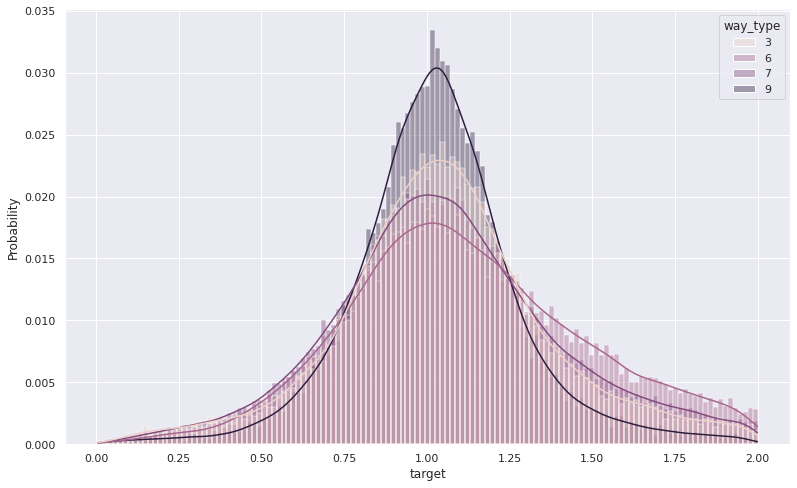

In [164]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(13,8)})
sns.histplot(data = test_data[test_data['target']<2], x= 'target',stat='probability',hue='way_type',common_norm=False,alpha=0.4,kde=True)

In [134]:
df_eta = (
    df_cleaned.withColumn('etaBucket',F.round(5*F.round(F.col('eta')/5),0))
              .groupBy('etaBucket')
              .agg(F.round(F.mean('targetError'),2).alias('error rate'))
              .orderBy('etaBucket')
)

df_eta.show(100,False)

+---------+----------+
|etaBucket|error rate|
+---------+----------+
|5.0      |22.3      |
|10.0     |28.64     |
|15.0     |39.15     |
|20.0     |53.81     |
|25.0     |56.65     |
|30.0     |49.79     |
|35.0     |45.74     |
|40.0     |38.31     |
|45.0     |36.39     |
|50.0     |30.36     |
|55.0     |30.38     |
|60.0     |30.54     |
|65.0     |34.49     |
|70.0     |22.9      |
|75.0     |27.93     |
|80.0     |30.44     |
|85.0     |24.4      |
|90.0     |27.13     |
|95.0     |21.96     |
|100.0    |18.84     |
|105.0    |25.41     |
|110.0    |27.2      |
|115.0    |15.03     |
|120.0    |22.81     |
|125.0    |19.24     |
|130.0    |15.26     |
|135.0    |19.54     |
|140.0    |28.13     |
|145.0    |26.81     |
|150.0    |12.73     |
|155.0    |17.56     |
|160.0    |14.86     |
|165.0    |36.2      |
|170.0    |34.48     |
|175.0    |16.09     |
|180.0    |12.59     |
|185.0    |15.06     |
|190.0    |32.86     |
|195.0    |34.07     |
|200.0    |13.59     |
|205.0    |

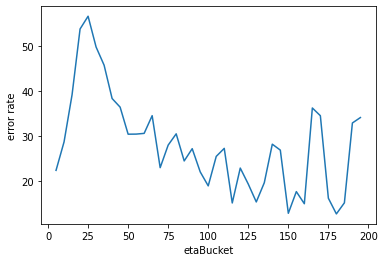

In [135]:
eta_plot = df_eta.toPandas()
sns.lineplot(data = eta_plot[eta_plot['etaBucket']<200
                                ] , x='etaBucket',y='error rate' )

In [58]:
df_features.agg(F.mean('isInTehran')).show()

+------------------+
|   avg(isInTehran)|
+------------------+
|0.2520779427282846|
+------------------+



In [146]:
(
    df_cleaned.filter(F.col('speed')<=150)
              .filter(F.col('coverage').between(0.85,1.05))
              .filter(F.col('is_tunnel')==0)
              .filter(F.col('length')<=2500)
              .filter(F.col('way_type')==9)
              .agg(F.round(F.mean('targetError'),2).alias('error rate'))
).show()

+----------+
|error rate|
+----------+
|     20.98|
+----------+



In [147]:
# Data
from sklearn.model_selection import train_test_split

features_train = df_features.toPandas()
#features_test = test_cleaned.toPandas()

#X = ['length','eta','coverage','way_segments_count','latitude','longitude','timeOfDay','dayOfWeek','way_type']

Train_Fetures = features_train[['length','eta','coverage','latitude','longitude','timeOfDay']]
Train_Target = features_train[['target','ata']]

# Fit
train_X, test_X, train_y, test_y = train_test_split(Train_Fetures, Train_Target, test_size=0.1)

In [153]:
import xgboost as xgb
# Fit
train_X, test_X, train_y, test_y = train_test_split(Train_Fetures, Train_Target, test_size=0.1)
g = test_X[['eta']]
#train_X = pca.transform(train_X)
#test_X = pca.transform(test_X)

model = xgb.XGBRegressor(learing_rate = 0.15,
                         max_depth=15,
                         n_estimators=350,
                         min_child_weight=3,
                         eval_metric='mae')

eval_set = [(train_X, train_y['target']), (test_X, test_y['target'])]
model.fit(train_X, (train_y['target']).values.ravel(), early_stopping_rounds=25, eval_metric=["mae"], eval_set=eval_set, verbose=True)

[10:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.531832	validation_1-mae:0.533846
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.484207	validation_1-mae:0.490327
[2]	validation_0-mae:0.442193	validation_1-mae:0.454565
[3]	validation_0-mae:0.405022	validation_1-mae:0.42059
[4]	validation_0-mae:0.3725	validation_1-mae:0.3947
[5]	validation_0-mae:0.34357	validation_1-mae:0.370294
[6]	validation_0-mae:0.31852	validation_1-mae:0.349895
[7]	validation_0-mae:0.296816	validation_1-mae:0.334987
[8]	validation_0-mae:0.278263	validation_1-mae:0.321712
[9]	validation_0-mae:0.262515	validation_1-mae:0.313183
[10]	validation_0-mae:0.249959	validation_1-mae:0.306592
[11]	validation_0-mae:0.239593	validation_1-mae:0.301875
[12]	validation_0-mae:0.230798	validation_1-mae:0

XGBRegressor(eval_metric='mae', learing_rate=0.15, max_depth=15,
             min_child_weight=3, n_estimators=350)

In [154]:
y_predicted =  model.predict(test_X)
prediction = g
prediction['predicted ATA'] = (prediction['eta']) * y_predicted
prediction['ata'] = test_y['ata']

prediction['error'] = abs((prediction['predicted ATA']-prediction['ata'])/(prediction['ata']))* 100

prediction['error'].describe()

count    1854.000000
mean       22.126226
std        76.839993
min         0.008581
25%         6.109541
50%        13.654967
75%        24.438840
max      2890.250608
Name: error, dtype: float64

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_X)

#X = pca.transform(train_X)

PCA(n_components=2)

In [23]:
print(pca.explained_variance_ratio_)

[9.99474367e-01 3.79126777e-04]


In [ ]:
x_pca = [row[0] for row in train_X]
x_pca

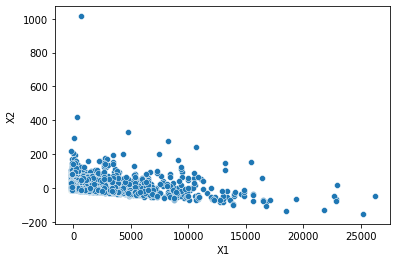

In [38]:
import seaborn as sns

pandas_df = pd.DataFrame()
pandas_df['X1'] = [row[0] for row in train_X]
pandas_df['X2'] = [row[1] for row in train_X]

sns.scatterplot(data = pandas_df, x ='X1',y='X2')

In [128]:
import xgboost as xgb
# Fit
train_X, test_X, train_y, test_y = train_test_split(Train_Fetures, Train_Target, test_size=0.1)
g = test_X[['eta']]
#train_X = pca.transform(train_X)
#test_X = pca.transform(test_X)

model = xgb.XGBRegressor(learing_rate = 0.2,
                         max_depth=10,
                         n_estimators=200,
                         min_child_weight=3,
                         eval_metric='mae')

eval_set = [(train_X, train_y['target']), (test_X, test_y['target'])]
model.fit(train_X, (train_y['target']).values.ravel(), early_stopping_rounds=25, eval_metric=["mae"], eval_set=eval_set, verbose=True)

[07:59:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.537532	validation_1-mae:0.564004
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.491929	validation_1-mae:0.519675
[2]	validation_0-mae:0.453043	validation_1-mae:0.482769
[3]	validation_0-mae:0.420461	validation_1-mae:0.451508
[4]	validation_0-mae:0.393276	validation_1-mae:0.425945
[5]	validation_0-mae:0.371434	validation_1-mae:0.405647
[6]	validation_0-mae:0.354278	validation_1-mae:0.390244
[7]	validation_0-mae:0.341124	validation_1-mae:0.378521
[8]	validation_0-mae:0.331123	validation_1-mae:0.370356
[9]	validation_0-mae:0.324066	validation_1-mae:0.365027
[10]	validation_0-mae:0.318938	validation_1-mae:0.36132
[11]	validation_0-mae:0.315605	validation_1-mae:0.358886
[12]	validation_0-mae:0.313316	validation_1

XGBRegressor(eval_metric='mae', learing_rate=0.2, max_depth=10,
             min_child_weight=3, n_estimators=200)

In [129]:
y_predicted =  model.predict(test_X)
prediction = g
prediction['predicted ATA'] = (prediction['eta']) * y_predicted
prediction['ata'] = test_y['ata']

prediction['error'] = abs((prediction['predicted ATA']-prediction['ata'])/(prediction['ata']))* 100

prediction['error'].describe()

count    13589.000000
mean        26.825047
std         36.915519
min          0.000125
25%          8.384909
50%         18.415641
75%         34.348005
max       1744.781827
Name: error, dtype: float64

In [115]:
# Predcition
y_predicted =  model.predict(test_X)
prediction = g
prediction['predicted ATA'] = y_predicted
prediction['ata'] = test_y['ata']

prediction['error'] = abs((prediction['predicted ATA']-prediction['ata'])/(prediction['ata']))* 100

prediction['error'].describe()

count    13589.000000
mean        26.991761
std         35.344519
min          0.001704
25%          8.682044
50%         18.596664
75%         34.356637
max       1478.289948
Name: error, dtype: float64

In [ ]:
from sklearn.svm import SVR



#Test_Features = features_test



svr_rbf = SVR(kernel="rbf")
svr_rbf.fit(train_X,train_y['ata']) 

In [ ]:
svr_rbf.coef_

In [ ]:
# Predcition
y_predicted =  svr_rbf.predict(test_X)
prediction = test_X[['eta','coverage']]
prediction['predicted ATA'] = y_predicted
prediction['ata'] = test_y['ata']

prediction['error'] = abs((prediction['predicted ATA']-prediction['ata'])/(prediction['ata']))* 100

prediction['error'].describe()

In [ ]:
# Predcition
y_predicted =  clf.predict(test_X)
prediction = test_X[['eta','coverage']]
prediction['predicted ATA'] = (prediction['eta']) * y_predicted
prediction['ata'] = test_y['ata']

prediction['error'] = abs((prediction['predicted ATA']-prediction['ata'])/(prediction['ata']))* 100

prediction['error'].describe()

count    11131.000000
mean        34.008895
std         35.805593
min          0.001789
25%         10.967903
50%         24.091014
75%         44.403563
max        400.127538
Name: error, dtype: float64